<a href="https://colab.research.google.com/github/youssefhedhili/miscellaneous/blob/master/3_Keras_with_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing Libraries and modules**

In [0]:
#Let's start by importing numpy and setting a seed for the computer's pseudorandom number generator. This allows us to reproduce the results from our script:
import numpy as np
np.random.seed(123)  # for reproducibility

In [0]:
#Next, we'll import the Sequential model type from Keras. This is simply a linear stack of neural network layers, and it's perfect for the type of feed-forward CNN we're building in this tutorial.
#Keras model module
from keras.models import Sequential

Using TensorFlow backend.


In [0]:
#Next, let's import the "core" layers from Keras. These are the layers that are used in almost any neural network:
from keras.layers import Dense, Dropout, Activation, Flatten

In [0]:
#Then, we'll import the CNN layers from Keras. These are the convolutional layers that will help us efficiently train on image data:
from keras.layers import Convolution2D, MaxPooling2D

In [0]:
#Finally, we'll import some utilities. This will help us transform our data later:
from keras.utils import np_utils

**Load image data from MNIST**

In [0]:
#MNIST is a great dataset for getting started with deep learning and computer vision. It's a big enough challenge to warrant neural networks, but it's manageable on a single computer
from keras.datasets import mnist
 
# Load pre-shuffled MNIST data into train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [0]:
#We can look at the shape of the dataset:
print(X_train.shape)

(60000, 28, 28)


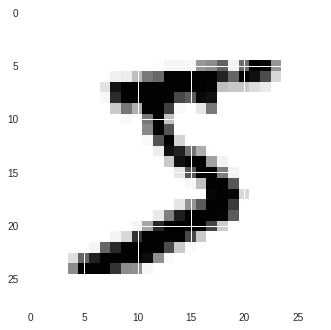

In [0]:
# Great, so it appears that we have 60,000 samples in our training set, and the images are 28 pixels x 28 pixels each. We can confirm this by plotting the first sample in matplotlib
X_show = X_train
Y_show = y_train

from matplotlib import pyplot as plt
plt.imshow(X_train[0])

In [0]:
from keras import backend as K
K.set_image_dim_ordering('th')
# input image dimensions
img_rows, img_cols = 28, 28


if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)

In [0]:
#When using the Theano backend, you must explicitly declare a dimension for the depth of the input image. For example, a full-color image with all 3 RGB channels will have a depth of 3.
#Our MNIST images only have a depth of 1, but we must explicitly declare that.
#In other words, we want to transform our dataset from having shape (n, width, height) to (n, depth, width, height).
#Here's how we can do that easily:

#Convert data type and normalize values

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

print(X_train.shape)




(60000, 1, 28, 28)


**Preprocess class labels for Keras**

In [0]:
#Next, let's take a look at the shape of our class label data:

print(y_train.shape)

(60000,)


In [0]:
#Hmm... that may be problematic. We should have 10 different classes, one for each digit, 
#but it looks like we only have a 1-dimensional array. Let's take a look at the labels for the first 10 training samples:

print(y_train[:10])

[5 0 4 1 9 2 1 3 1 4]


In [0]:
from keras import backend as K
K.set_image_dim_ordering('th')
#And there's the problem. The y_train and y_test data are not split into 10 distinct class labels, but rather are represented as a single array with the class values.
#We can fix this easily:

# Convert 1-dimensional class arrays to 10-dimensional class matrices
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

In [0]:
#Now we can take another look:

print(Y_train.shape)

(60000, 10)


**Define model architecture**

In [0]:
#Let's start by declaring a sequential model format:
model = Sequential()

In [0]:
#Next, we declare the input layer:
#CNN input layer

model.add(Convolution2D(32, 3, 3, activation='relu', input_shape=(1,28,28)))

Instructions for updating:
Colocations handled automatically by placer.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", input_shape=(1, 28, 28...)`
  


In [0]:
#The input shape parameter should be the shape of 1 sample. In this case, it's the same (1, 28, 28) that corresponds to  the (depth, width, height) of each digit image.
#But what do the first 3 parameters represent? They correspond to the number of convolution filters to use, the number of rows in each convolution kernel, and the number of columns in each convolution kernel, 
#respectively.We can confirm this by printing the shape of the current model output:

print(model.output_shape)

(None, 32, 26, 26)


In [0]:
#Next, we can simply add more layers to our model like we're building legos:

model.add(Convolution2D(32, 3, 3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu")`
  


In [0]:
#Again, we won't go into the theory too much, but it's important to highlight the Dropout layer we just added. This is a method for regularizing our model in order to prevent overfitting.
#MaxPooling2D is a way to reduce the number of parameters in our model by sliding a 2x2 pooling filter across the previous layer and taking the max of the 4 values in the 2x2 filter.
#So far, for model parameters, we've added two Convolution layers. To complete our model architecture, let's add a fully connected layer and then the output layer:

#Fully connected Dense layersPython

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

In [0]:
#For Dense layers, the first parameter is the output size of the layer. Keras automatically handles the connections between layers.
#Note that the final layer has an output size of 10, corresponding to the 10 classes of digits.
#Also note that the weights from the Convolution layers must be flattened (made 1-dimensional) before passing them to the fully connected Dense layer.

#Model architecture
# model = Sequential()
 
# model.add(Convolution2D(32, 3, 3, activation='relu', input_shape=(1,28,28)))
# model.add(Convolution2D(32, 3, 3, activation='relu'))
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Dropout(0.25))
 
# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(10, activation='softmax'))

**Compile the model**

In [0]:
#When we compile the model, we declare the loss function and the optimizer (SGD, Adam, etc.).
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

**Fit model on training data**

In [0]:
#To fit the model, all we have to do is declare the batch size and number of epochs to train for, then pass in our training data.
#Fit Keras model
model.fit(X_train, Y_train, 
          batch_size=32, nb_epoch=10, verbose=1)

Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Epoch 1/10
60000/60000 [==============================] - 18s 301us/step - loss: 0.2048 - acc: 0.9368
Epoch 2/10
60000/60000 [==============================] - 17s 280us/step - loss: 0.0865 - acc: 0.9740
Epoch 3/10
60000/60000 [==============================] - 17s 280us/step - loss: 0.0659 - acc: 0.9805
Epoch 4/10
60000/60000 [==============================] - 17s 280us/step - loss: 0.0557 - acc: 0.9834
Epoch 5/10
60000/60000 [==============================] - 17s 280us/step - loss: 0.0452 - acc: 0.9860
Epoch 6/10
60000/60000 [==============================] - 17s 280us/step - loss: 0.0425 - acc: 0.9868
Epoch 7/10
60000/60000 [==============================] - 17s 280us/step - loss: 0.0359 - acc: 0.9884
Epoch 8/10
60000/60000 [==============================] - 17s 279us/step - loss: 0.0331 - acc: 0.9893
Epoch 9/10
60000/60000 [==============================] - 17s 279us/step - loss: 0.0315 - acc: 0.9902
Epoch 10/10
60000/60000 [==============================] - 17s 280us/step - loss: 

**Evaluate model on test data**

In [0]:
#Finally, we can evaluate our model on the test data:

score = model.evaluate(X_test, Y_test, verbose=0)
print(score)

[0.027494018173711266, 0.9921]
